### Image Preprocessing Pipeline

This notebook covers image quality control and preprocessing for handwritten answer sheets:

1. **Blur Detection** - Laplacian variance
2. **Angle Correction** - Hough transform
3. **Lighting Normalization** - CLAHE
4. **Best Frame Selection** - From video input

---

## Setup & Imports

In [1]:
# Install dependencies if needed
# !pip install opencv-python numpy matplotlib pillow

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from typing import Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

# Display settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print(f"OpenCV version: {cv2.__version__}")

OpenCV version: 4.12.0


---
## 1. Blur Detection (Laplacian Variance)

Blur detection helps identify low-quality images that would be difficult to process.

**Method:** Calculate the variance of the Laplacian operator. Higher variance = sharper image.

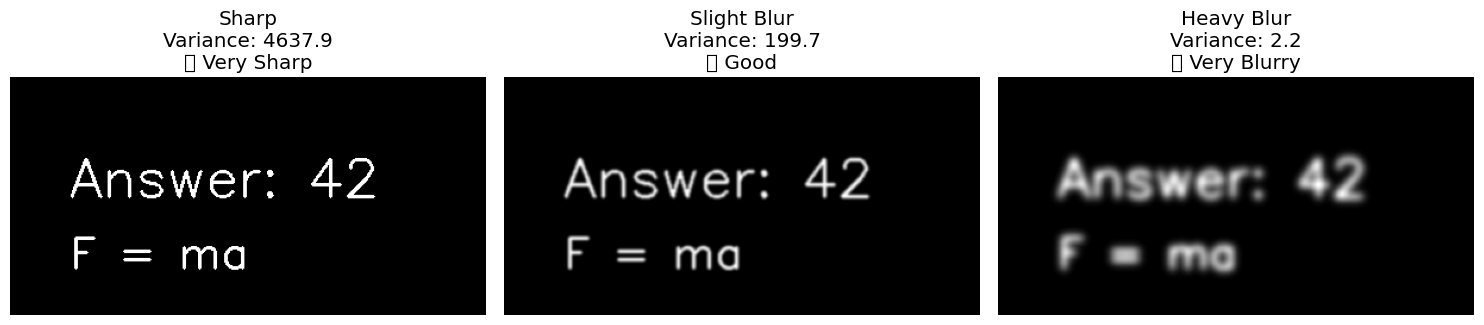

In [3]:
def detect_blur(image: np.ndarray, threshold: float = 100.0) -> Tuple[float, bool, str]:
    """
    Detect if an image is blurry using Laplacian variance.
    
    Args:
        image: Input image (BGR or grayscale)
        threshold: Variance threshold (lower = blurry)
        
    Returns:
        (variance_score, is_blurry, quality_label)
    
    Reference:
        - Laplacian operator detects edges
        - High variance = many edges = sharp image
        - Low variance = few edges = blurry image
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Calculate Laplacian
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    
    # Compute variance
    variance = laplacian.var()
    
    # Determine quality
    is_blurry = variance < threshold
    
    if variance < 50:
        quality = "❌ Very Blurry"
    elif variance < 100:
        quality = "⚠️ Slightly Blurry"
    elif variance < 300:
        quality = "✅ Good"
    else:
        quality = "✅ Very Sharp"
    
    return variance, is_blurry, quality


# Test with synthetic images
def demo_blur_detection():
    """Demonstrate blur detection with synthetic images."""
    
    # Create a test image with text-like patterns
    img = np.zeros((200, 400), dtype=np.uint8)
    cv2.putText(img, "Answer: 42", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, 255, 2)
    cv2.putText(img, "F = ma", (50, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.2, 255, 2)
    
    # Create blurred versions
    img_sharp = img.copy()
    img_slight_blur = cv2.GaussianBlur(img, (5, 5), 0)
    img_heavy_blur = cv2.GaussianBlur(img, (21, 21), 0)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for ax, (img_test, title) in zip(axes, [
        (img_sharp, "Sharp"),
        (img_slight_blur, "Slight Blur"),
        (img_heavy_blur, "Heavy Blur")
    ]):
        variance, is_blurry, quality = detect_blur(img_test)
        ax.imshow(img_test, cmap='gray')
        ax.set_title(f"{title}\nVariance: {variance:.1f}\n{quality}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
demo_blur_detection()

---
## 2. Angle Correction (Deskewing)

Answer sheets may be photographed at an angle. We detect and correct this using:
- Hough Line Transform to find document edges
- Rotation to align horizontally

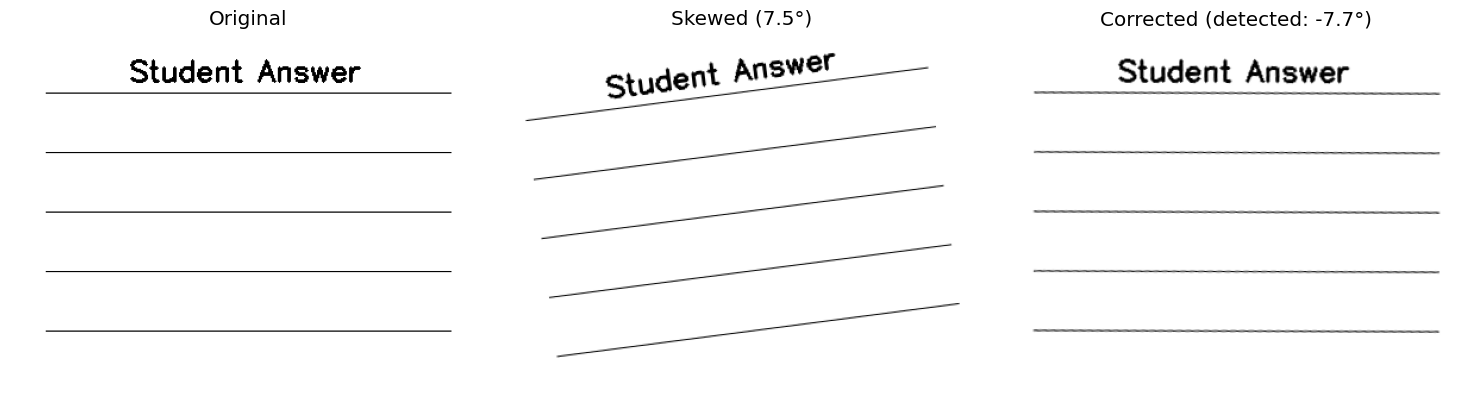

In [4]:
def detect_skew_angle(image: np.ndarray) -> float:
    """
    Detect skew angle of a document image.
    
    Uses Hough Line Transform to find dominant lines,
    then calculates the median angle.
    
    Returns:
        Skew angle in degrees
    """
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Hough Line Transform
    lines = cv2.HoughLinesP(
        edges, 
        rho=1, 
        theta=np.pi/180, 
        threshold=100,
        minLineLength=100,
        maxLineGap=10
    )
    
    if lines is None:
        return 0.0
    
    # Calculate angles of all lines
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        # Filter to near-horizontal lines (±45°)
        if -45 < angle < 45:
            angles.append(angle)
    
    if not angles:
        return 0.0
    
    return np.median(angles)


def correct_skew(image: np.ndarray, angle: float = None) -> np.ndarray:
    """
    Rotate image to correct skew.
    
    Args:
        image: Input image
        angle: Rotation angle (auto-detected if None)
        
    Returns:
        Deskewed image
    """
    if angle is None:
        angle = detect_skew_angle(image)
    
    if abs(angle) < 0.5:  # Skip if angle is negligible
        return image
    
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Rotate image
    rotated = cv2.warpAffine(
        image, M, (w, h),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_REPLICATE
    )
    
    return rotated


# Demo
def demo_deskew():
    """Demonstrate skew detection and correction."""
    
    # Create a test document image
    img = np.ones((300, 400), dtype=np.uint8) * 255
    for i in range(5):
        y = 50 + i * 50
        cv2.line(img, (30, y), (370, y), 0, 1)
    cv2.putText(img, "Student Answer", (100, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 0, 2)
    
    # Rotate to simulate skewed capture
    skew_angle = 7.5
    h, w = img.shape
    M = cv2.getRotationMatrix2D((w//2, h//2), skew_angle, 1.0)
    skewed = cv2.warpAffine(img, M, (w, h), borderValue=255)
    
    # Detect and correct
    detected_angle = detect_skew_angle(skewed)
    corrected = correct_skew(skewed, detected_angle)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Original")
    axes[1].imshow(skewed, cmap='gray')
    axes[1].set_title(f"Skewed ({skew_angle}°)")
    axes[2].imshow(corrected, cmap='gray')
    axes[2].set_title(f"Corrected (detected: {detected_angle:.1f}°)")
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

demo_deskew()

---
## 3. Lighting Normalization (CLAHE)

Uneven lighting can make text difficult to read. We use:
- **CLAHE** (Contrast Limited Adaptive Histogram Equalization)
- Operates on small regions for local contrast enhancement

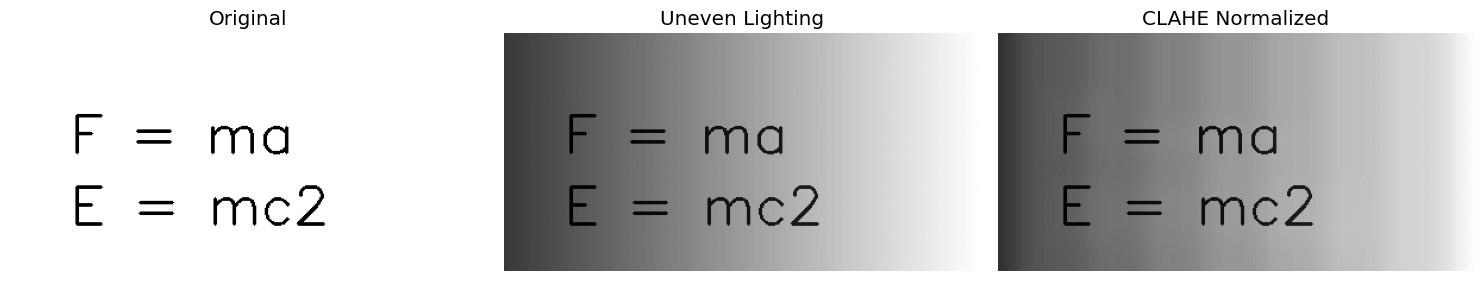

In [5]:
def normalize_lighting(image: np.ndarray, clip_limit: float = 2.0, tile_size: int = 8) -> np.ndarray:
    """
    Normalize lighting using CLAHE.
    
    Args:
        image: Input image (BGR or grayscale)
        clip_limit: Contrast limiting threshold
        tile_size: Size of local regions
        
    Returns:
        Lighting-normalized image
    """
    # Convert to LAB color space for better lighting control
    if len(image.shape) == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
    else:
        l = image.copy()
        is_gray = True
    
    # Apply CLAHE to luminance channel
    clahe = cv2.createCLAHE(
        clipLimit=clip_limit, 
        tileGridSize=(tile_size, tile_size)
    )
    l_normalized = clahe.apply(l)
    
    if len(image.shape) == 3:
        # Merge back
        lab_normalized = cv2.merge([l_normalized, a, b])
        return cv2.cvtColor(lab_normalized, cv2.COLOR_LAB2BGR)
    else:
        return l_normalized


# Demo
def demo_lighting():
    """Demonstrate lighting normalization."""
    
    # Create image with uneven lighting
    img = np.ones((200, 400), dtype=np.uint8) * 200
    cv2.putText(img, "F = ma", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, 50, 2)
    cv2.putText(img, "E = mc2", (50, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, 50, 2)
    
    # Add gradient to simulate uneven lighting
    gradient = np.linspace(0.3, 1.0, img.shape[1])
    gradient = np.tile(gradient, (img.shape[0], 1))
    uneven = (img * gradient).astype(np.uint8)
    
    # Normalize
    normalized = normalize_lighting(uneven)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Original")
    axes[1].imshow(uneven, cmap='gray')
    axes[1].set_title("Uneven Lighting")
    axes[2].imshow(normalized, cmap='gray')
    axes[2].set_title("CLAHE Normalized")
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

demo_lighting()

---
## 4. Best Frame Selection (Video Input)

For video capture, we automatically select the sharpest frame:

In [6]:
def extract_best_frame(video_path: str, sample_every: int = 5) -> Tuple[np.ndarray, int, float]:
    """
    Extract the sharpest frame from a video.
    
    Args:
        video_path: Path to video file
        sample_every: Sample every N frames for efficiency
        
    Returns:
        (best_frame, frame_index, blur_score)
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    best_frame = None
    best_score = -1
    best_idx = -1
    
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Sample every N frames
        if frame_idx % sample_every == 0:
            score, is_blurry, _ = detect_blur(frame)
            
            if score > best_score:
                best_score = score
                best_frame = frame.copy()
                best_idx = frame_idx
        
        frame_idx += 1
    
    cap.release()
    
    if best_frame is None:
        raise ValueError("No valid frames found in video")
    
    return best_frame, best_idx, best_score


def extract_frames_with_scores(video_path: str, max_frames: int = 100) -> List[Tuple[np.ndarray, float]]:
    """
    Extract frames with their quality scores.
    
    Returns:
        List of (frame, blur_score) tuples
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    sample_every = max(1, total_frames // max_frames)
    
    frames = []
    frame_idx = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_idx % sample_every == 0:
            score, _, _ = detect_blur(frame)
            frames.append((frame.copy(), score))
        
        frame_idx += 1
    
    cap.release()
    return frames


print("✅ Video frame extraction functions defined")
print("Note: Run with actual video file to test")

✅ Video frame extraction functions defined
Note: Run with actual video file to test


---
## 5. Complete Preprocessing Pipeline

Combine all preprocessing steps into a single pipeline:

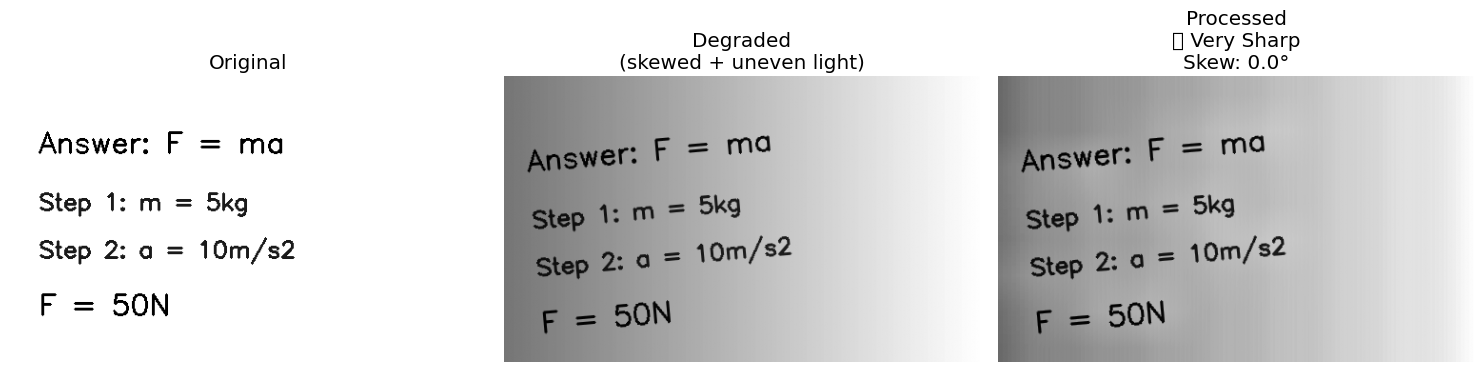


📊 Processing Results:
   Quality Score: 410.1
   Quality Label: ✅ Very Sharp
   Is Acceptable: True
   Skew Angle: 0.00°
   Steps Applied: ['quality_check', 'lighting_normalization', 'deskew']


In [7]:
class ImagePreprocessor:
    """
    Complete preprocessing pipeline for answer sheet images.
    
    Pipeline:
    1. Quality check (blur detection)
    2. Lighting normalization (CLAHE)
    3. Angle correction (deskew)
    4. Binarization (optional)
    """
    
    def __init__(
        self,
        blur_threshold: float = 100.0,
        clahe_clip_limit: float = 2.0,
        auto_deskew: bool = True,
        binarize: bool = False
    ):
        self.blur_threshold = blur_threshold
        self.clahe_clip_limit = clahe_clip_limit
        self.auto_deskew = auto_deskew
        self.binarize = binarize
    
    def process(self, image: np.ndarray) -> dict:
        """
        Run full preprocessing pipeline.
        
        Returns:
            dict with:
            - 'image': Processed image
            - 'quality_score': Blur variance score
            - 'quality_label': Human-readable quality
            - 'is_acceptable': Whether image passed quality check
            - 'skew_angle': Detected/corrected angle
        """
        result = {
            'original': image.copy(),
            'steps': []
        }
        
        # Step 1: Quality check
        quality_score, is_blurry, quality_label = detect_blur(image, self.blur_threshold)
        result['quality_score'] = quality_score
        result['quality_label'] = quality_label
        result['is_acceptable'] = not is_blurry
        result['steps'].append('quality_check')
        
        current = image.copy()
        
        # Step 2: Lighting normalization
        current = normalize_lighting(current, self.clahe_clip_limit)
        result['steps'].append('lighting_normalization')
        
        # Step 3: Deskew
        if self.auto_deskew:
            skew_angle = detect_skew_angle(current)
            if abs(skew_angle) > 0.5:
                current = correct_skew(current, skew_angle)
            result['skew_angle'] = skew_angle
            result['steps'].append('deskew')
        else:
            result['skew_angle'] = 0.0
        
        # Step 4: Binarization (optional)
        if self.binarize:
            if len(current.shape) == 3:
                gray = cv2.cvtColor(current, cv2.COLOR_BGR2GRAY)
            else:
                gray = current
            current = cv2.adaptiveThreshold(
                gray, 255,
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY,
                11, 2
            )
            result['steps'].append('binarization')
        
        result['image'] = current
        return result
    
    def process_video(self, video_path: str) -> dict:
        """
        Process video and return best frame.
        """
        best_frame, frame_idx, score = extract_best_frame(video_path)
        result = self.process(best_frame)
        result['source'] = 'video'
        result['frame_index'] = frame_idx
        return result


# Test the pipeline
def demo_pipeline():
    """Demonstrate the complete pipeline."""
    
    # Create test image
    img = np.ones((300, 500), dtype=np.uint8) * 220
    cv2.putText(img, "Answer: F = ma", (30, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.0, 30, 2)
    cv2.putText(img, "Step 1: m = 5kg", (30, 140), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 50, 2)
    cv2.putText(img, "Step 2: a = 10m/s2", (30, 190), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 50, 2)
    cv2.putText(img, "F = 50N", (30, 250), cv2.FONT_HERSHEY_SIMPLEX, 1.0, 30, 2)
    
    # Add some degradation
    h, w = img.shape
    M = cv2.getRotationMatrix2D((w//2, h//2), 5, 1.0)
    degraded = cv2.warpAffine(img, M, (w, h), borderValue=220)
    gradient = np.linspace(0.5, 1.0, w)
    degraded = (degraded * np.tile(gradient, (h, 1))).astype(np.uint8)
    
    # Process
    preprocessor = ImagePreprocessor()
    result = preprocessor.process(degraded)
    
    # Display
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Original")
    axes[1].imshow(degraded, cmap='gray')
    axes[1].set_title("Degraded\n(skewed + uneven light)")
    axes[2].imshow(result['image'], cmap='gray')
    axes[2].set_title(f"Processed\n{result['quality_label']}\nSkew: {result['skew_angle']:.1f}°")
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Processing Results:")
    print(f"   Quality Score: {result['quality_score']:.1f}")
    print(f"   Quality Label: {result['quality_label']}")
    print(f"   Is Acceptable: {result['is_acceptable']}")
    print(f"   Skew Angle: {result['skew_angle']:.2f}°")
    print(f"   Steps Applied: {result['steps']}")

demo_pipeline()

---
## 6. Export for Production Use

Export the preprocessing utilities to a Python module:

In [8]:
# Export to ml/utils/preprocessing.py
PREPROCESSING_MODULE = '''
"""
Image Preprocessing Utilities for Answer Sheet Evaluation

Functions:
- detect_blur: Check image sharpness
- detect_skew_angle: Find document rotation
- correct_skew: Rotate to correct angle
- normalize_lighting: CLAHE enhancement
- extract_best_frame: Get sharpest video frame
- ImagePreprocessor: Complete pipeline class
"""
import cv2
import numpy as np
from typing import Tuple, List, Optional


def detect_blur(image: np.ndarray, threshold: float = 100.0) -> Tuple[float, bool, str]:
    """Detect if image is blurry using Laplacian variance."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    variance = laplacian.var()
    is_blurry = variance < threshold
    
    if variance < 50:
        quality = "very_blurry"
    elif variance < 100:
        quality = "slightly_blurry"
    elif variance < 300:
        quality = "good"
    else:
        quality = "very_sharp"
    
    return variance, is_blurry, quality


def detect_skew_angle(image: np.ndarray) -> float:
    """Detect skew angle using Hough lines."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
    
    if lines is None:
        return 0.0
    
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        if -45 < angle < 45:
            angles.append(angle)
    
    return np.median(angles) if angles else 0.0


def correct_skew(image: np.ndarray, angle: float = None) -> np.ndarray:
    """Rotate image to correct skew."""
    if angle is None:
        angle = detect_skew_angle(image)
    
    if abs(angle) < 0.5:
        return image
    
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)


def normalize_lighting(image: np.ndarray, clip_limit: float = 2.0) -> np.ndarray:
    """Normalize lighting using CLAHE."""
    if len(image.shape) == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
    else:
        l = image.copy()
    
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    l_normalized = clahe.apply(l)
    
    if len(image.shape) == 3:
        lab_normalized = cv2.merge([l_normalized, a, b])
        return cv2.cvtColor(lab_normalized, cv2.COLOR_LAB2BGR)
    return l_normalized


def extract_best_frame(video_path: str, sample_every: int = 5) -> Tuple[np.ndarray, int, float]:
    """Extract sharpest frame from video."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    best_frame, best_score, best_idx = None, -1, -1
    frame_idx = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_idx % sample_every == 0:
            score, _, _ = detect_blur(frame)
            if score > best_score:
                best_score, best_frame, best_idx = score, frame.copy(), frame_idx
        frame_idx += 1
    
    cap.release()
    if best_frame is None:
        raise ValueError("No valid frames found")
    return best_frame, best_idx, best_score


class ImagePreprocessor:
    """Complete preprocessing pipeline."""
    
    def __init__(self, blur_threshold=100.0, clahe_clip=2.0, auto_deskew=True):
        self.blur_threshold = blur_threshold
        self.clahe_clip = clahe_clip
        self.auto_deskew = auto_deskew
    
    def process(self, image: np.ndarray) -> dict:
        """Run preprocessing pipeline."""
        quality_score, is_blurry, quality_label = detect_blur(image, self.blur_threshold)
        
        current = normalize_lighting(image, self.clahe_clip)
        
        skew_angle = 0.0
        if self.auto_deskew:
            skew_angle = detect_skew_angle(current)
            if abs(skew_angle) > 0.5:
                current = correct_skew(current, skew_angle)
        
        return {
            "image": current,
            "quality_score": quality_score,
            "quality_label": quality_label,
            "is_acceptable": not is_blurry,
            "skew_angle": skew_angle
        }
'''

# Save to file
output_path = Path("../utils/preprocessing.py")
output_path.parent.mkdir(parents=True, exist_ok=True)
output_path.write_text(PREPROCESSING_MODULE)
print(f"✅ Exported preprocessing module to: {output_path.resolve()}")

✅ Exported preprocessing module to: /Users/proxim/projects/ensureStudy/ml/utils/preprocessing.py


---
## Summary

This notebook covered:

| Function | Purpose |
|----------|--------|
| `detect_blur()` | Laplacian variance for sharpness |
| `detect_skew_angle()` | Hough transform for rotation |
| `correct_skew()` | Rotate to correct angle |
| `normalize_lighting()` | CLAHE for uneven light |
| `extract_best_frame()` | Video → sharpest frame |
| `ImagePreprocessor` | Complete pipeline class |

**Next:** HTR Model Training notebook